In [1]:
from src.gen.generator import EncoderDecoderV3
import torch
import seaborn as sns
import pandas as pd
from gru_pca import encode
from src.utils.finger import smiles2sparse
from sklearn.manifold import TSNE
import rdkit.Chem as Chem
import rdkit.Chem.QED
import rdkit.Chem.Draw as Draw
from src.utils.vectorizer import SELFIESVectorizer
import numpy as np
import selfies as sf
from src.pred.filter import get_largest_ring

model_path = 'models/GRUv3_gelu/epoch_200.pt'
model_name = model_path.split('/')[1]
epoch = model_path.split('_')[-1].split('.')[0]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

model = EncoderDecoderV3(fp_size=4860,
                         encoding_size=32,
                         hidden_size=512,
                         num_layers=2,
                         output_size=42,
                         dropout=0.1,
                         teacher_ratio=0.0,
                         fc1_size=4096,
                         fc2_size=2048,
                         fc3_size=1024,
                         random_seed=42,
                         encoder_activation='gelu',
                         ).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))

vectorizer = SELFIESVectorizer()

drugs = pd.read_csv('d2_drugs.csv')
smiles = drugs['smiles'].to_list()
molecule_names = drugs['name'].to_list()

fps = [torch.Tensor(smiles2sparse(smile)) for smile in smiles]
fps = [fp.unsqueeze(0).to(device) for fp in fps]
fps_tensor = torch.cat(fps, dim=0)
fp_encoded, _ = model.encoder(fps_tensor)
fp_encoded = fp_encoded.detach().cpu().numpy()

Using device: cuda


In [8]:
fp_encoded
norms = [np.linalg.norm(fp_encoded[n]) for n in range(len(fp_encoded))]
norms

[5.5726633,
 4.903553,
 4.043695,
 4.1968813,
 6.375942,
 6.628906,
 5.7641644,
 6.4143867,
 4.573254,
 6.495806,
 5.227794,
 5.4012976]

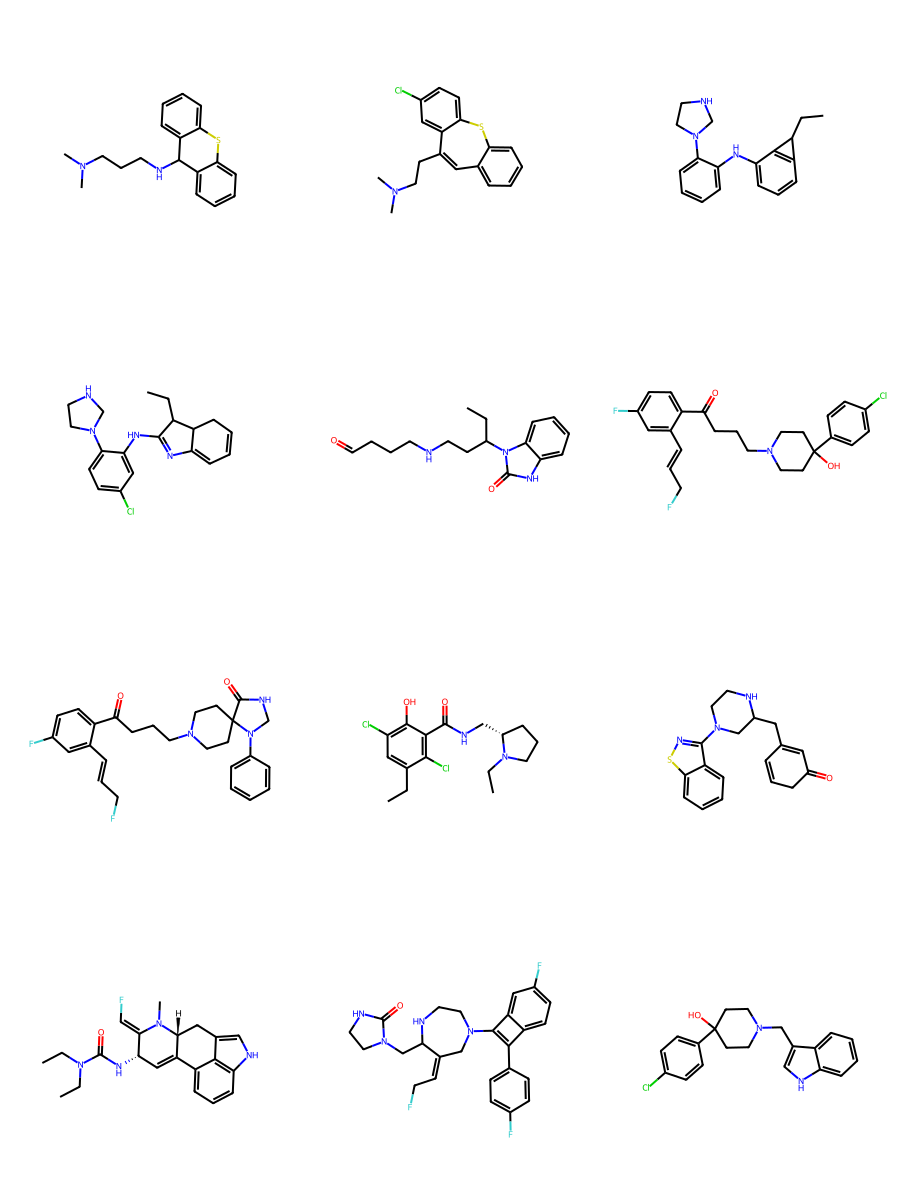

In [43]:
def extended_QED(mol, max_ring_size=7, penalty=4):
    qed = Chem.QED.qed(mol)
    largest_ring = get_largest_ring(mol)
    if largest_ring > max_ring_size:
        qed *= np.exp((max_ring_size-largest_ring)/penalty)
    return qed

def predict_with_dropout(model: EncoderDecoderV3, 
                         latent_vectors: np.array, 
                         n_iter: int=100, 
                         device: str='cuda',
                         return_imgs=True):
    device = torch.device(device)
    dataframes = []
    for n in range(n_iter):
        df = pd.DataFrame(columns=['smiles', 'score'])
        latent_tensor = torch.Tensor(latent_vectors).to(device)
        model = model.to(device)
        preds, _ = model(latent_tensor, None, omit_encoder=True)
        preds = preds.detach().cpu().numpy()
        preds = [vectorizer.devectorize(pred, remove_special=True) for pred in preds]
        smiles = [sf.decoder(x) for x in preds]
        mols = [Chem.MolFromSmiles(x) for x in smiles]
        scores = [extended_QED(mol) for mol in mols]
        df['smiles'] = smiles
        df['score'] = scores
        dataframes.append(df)
    
    best_smiles = []
    best_scores = []
    for n in range(len(latent_vectors)):
        scores = np.array([df['score'][n] for df in dataframes])
        best_idx = np.argmax(scores)
        best_smile = dataframes[best_idx]['smiles'][n]
        best_score = dataframes[best_idx]['score'][n]
        best_smiles.append(best_smile)
        best_scores.append(best_score)
    
    best_results = pd.DataFrame(columns=['smiles', 'score'])
    best_results['smiles'] = best_smiles
    best_results['score'] = best_scores
    
    if return_imgs:
        best_results['mol'] = best_results['smiles'].apply(Chem.MolFromSmiles)
        img = Draw.MolsToGridImage(best_results.mol.to_list(), molsPerRow=3, 
                                   subImgSize=(300, 300))
        best_results = best_results.drop('mol', axis=1)
        return best_results, img
    else:
        return best_results
    
best_preds, img = predict_with_dropout(model=model, 
                                      latent_vectors=fp_encoded,
                                      n_iter=100, 
                                      device='cuda',
                                      return_imgs=True)
img

In [42]:
best_preds

,smiles,score,mol
0,CN(C)CCCNC1C2=CC=CC=C2SC3=CC=CC=C31,0.845731,<rdkit.Chem.rdchem.Mol object at 0x7f3d5dd275e0>
1,CN(C)CCC1=CC2=CC=CC=C2CC3=CC=C(Cl)C=C31,0.790992,<rdkit.Chem.rdchem.Mol object at 0x7f3d5dd27d60>
2,CN1CCN1C2=CC=CC=C2NC=C3C=CC4=C3C4CCC,0.886669,<rdkit.Chem.rdchem.Mol object at 0x7f3d5dd277c0>
3,CNC1CN(C2=CC=C(Cl)C=C2NC3=NC4=CC=CC=C4C35C)C15,0.835082,<rdkit.Chem.rdchem.Mol object at 0x7f3d5dd27d00>
4,O=CCCCNCCC(N1C(=O)[NH1]C2=CC=CC=C21)CC,0.549352,<rdkit.Chem.rdchem.Mol object at 0x7f3d5dd271c0>
5,O=C(CCCN1CCC(O)(C2=CC=C(Cl)C=C2)CC1)C3=CC4=C(F...,0.563319,<rdkit.Chem.rdchem.Mol object at 0x7f3d5dd27580>
6,O=C(CCCN1CCC2(CC1)C(=O)NCN2C3=CC=CC=C3)C4=CC=C...,0.719106,<rdkit.Chem.rdchem.Mol object at 0x7f3d5dd27ee0>
7,CCC1=CC(Cl)=C(OC)C(C(=O)NC[C@@H1]2CCCN2CC)=C1Cl,0.840593,<rdkit.Chem.rdchem.Mol object at 0x7f3d5dd27040>
8,O=C1CC=CC(CC2NCCN(C3=N[NH1]C4=CC=CC=C34)C2)=C1,0.912270,<rdkit.Chem.rdchem.Mol object at 0x7f3d5dd276a0>
9,CCN(CC)C(=O)N[C@H1]1C=C2C3=CC=CC=4[NH1]C=C(C3=...,0.868841,<rdkit.Chem.rdchem.Mol object at 0x7f3d5dd27460>


In [ ]:
df = pd.read_parquet('data/activity_data/d2_klek_100nM.parquet')
d2_encoded, _ = encode(df, model, device)
fp_encoded_numpy = fp_encoded.detach().cpu().numpy()

cat = np.concatenate((fp_encoded_numpy, d2_encoded), axis=0)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_jobs=-1)

results = tsne.fit_transform(cat)

In [33]:
all_df = pd.DataFrame((results[-len(d2_encoded):]), columns=['x', 'y'])
activity = ['D2 active' if x == 1 else 'D2 inactive' for x in df['Class']]
all_df['activity'] = activity
drugs_df = pd.DataFrame((results[:-len(d2_encoded)]), columns=['x', 'y'])
drugs_df['name'] = molecule_names
drugs_df['n'] = range(1, len(drugs_df) + 1)

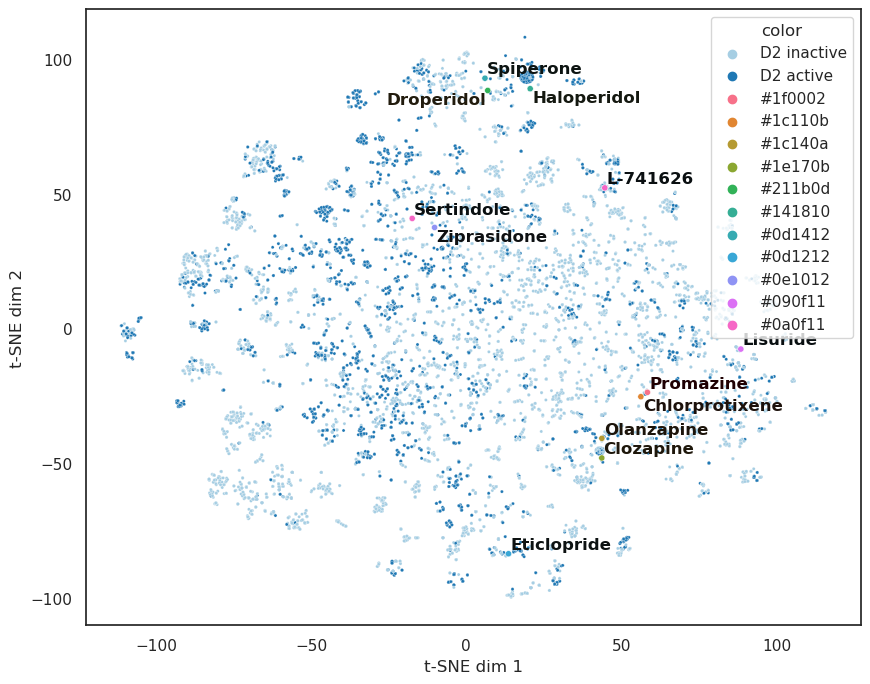

In [40]:
drugs_df['color'] = ["#1f0002",
                     "#1c110b",
                     "#1c140a",
                     "#1e170b",
                     "#211b0d",
                     "#141810",
                     "#0d1412",
                     "#0d1212",
                     "#0e1012",
                     "#090f11",
                     "#0a0f11",
                     "#0a0f11",
                    ]

import matplotlib.pyplot as plt
from adjustText import adjust_text

sns.set(rc={'figure.figsize':(10,8)})
sns.set_style("white")
with sns.color_palette("Paired"):
    sns.scatterplot(
        data=all_df,
        x="x", y="y", hue="activity", s=5
    )
sns.scatterplot(
    data=drugs_df,
    x="x", y="y", hue=drugs_df['color'], s=20
)
plt.xlabel('t-SNE dim 1')
plt.ylabel('t-SNE dim 2')

annotation_list = []
for line in range(0,drugs_df.shape[0]):
    annotation_list.append(
        plt.annotate(drugs_df['name'][line], xy=(drugs_df['x'][line], drugs_df['y'][line]), size=12,
        weight='bold', color=drugs_df['color'][line])
    )
adjust_text(annotation_list, expand=(10, 10))
     
plt.savefig(f'plots/{model_name}_epoch_{epoch}_tsne.png')

In [14]:
df = pd.read_csv('drugs.csv')
legends = df['name'].to_list()
for n, name in enumerate(legends):
    legends[n] = f'{n+1}. {name}'
df['mol'] = df['smiles'].apply(Chem.MolFromSmiles)
img = Draw.MolsToGridImage(df.mol.to_list(), molsPerRow=3, subImgSize=(300, 300), legends=legends)

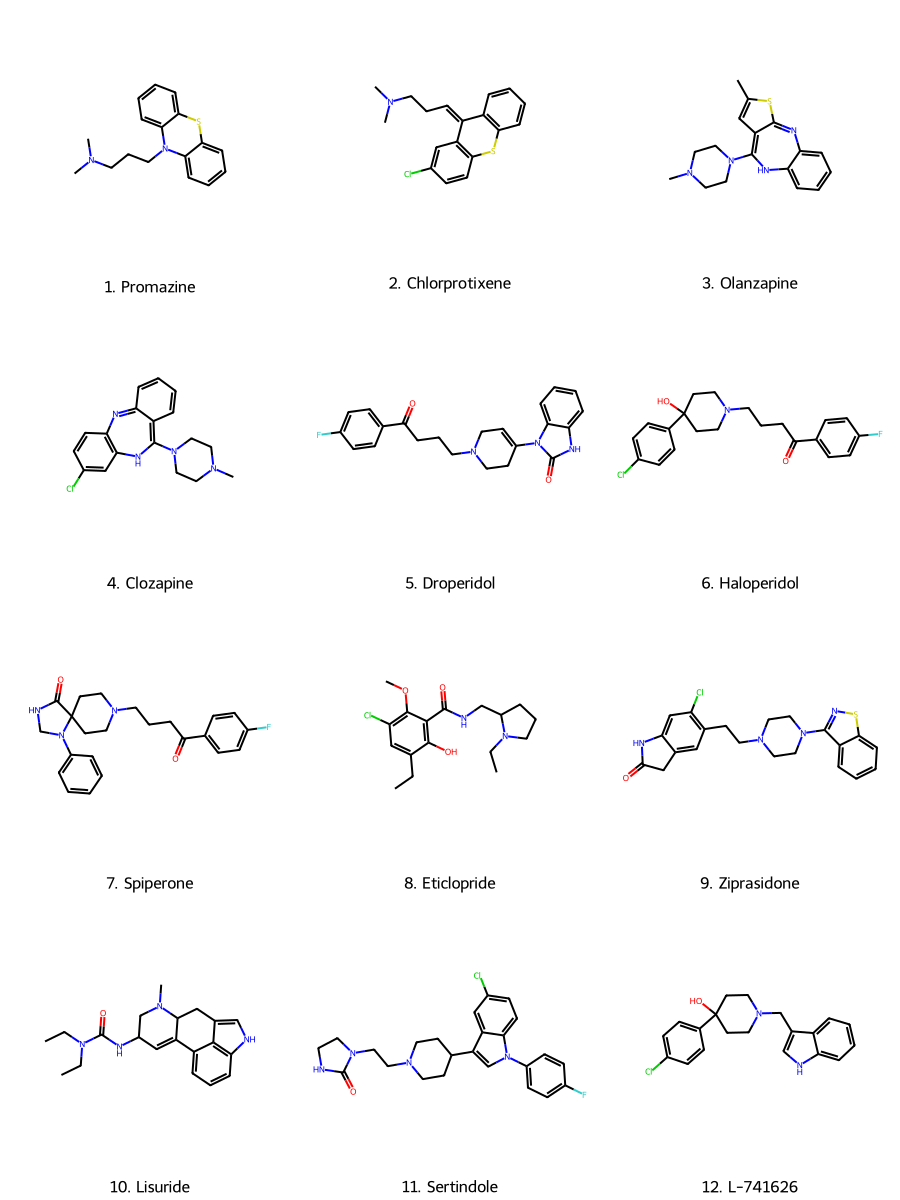

In [15]:
img

In [5]:
import pandas as pd

df = pd.read_csv('d2_drugs.csv')
df

,smiles,name
0,CN(C)CCCN1C2=CC=CC=C2SC3=CC=CC=C31,Promazine
1,Clc2cc1C(\c3c(Sc1cc2)cccc3)=C/CCN(C)C,Chlorprotixene
2,CC1=CC2=C(NC3=CC=CC=C3N=C2S1)N4CCN(CC4)C,Olanzapine
3,CN1CCN(CC1)C2=C3C=CC=CC3=NC4=C(N2)C=C(C=C4)Cl,Clozapine
4,FC1=CC=C(C=C1)C(=O)CCCN1CCC(=CC1)N1C(=O)NC2=CC...,Droperidol
5,OC1(CCN(CCCC(=O)C2=CC=C(F)C=C2)CC1)C1=CC=C(Cl)...,Haloperidol
6,c1ccc(cc1)N2CNC(=O)C23CCN(CC3)CCCC(=O)c4ccc(cc4)F,Spiperone
7,CCC1=CC(=C(C(=C1O)C(=O)NCC2CCCN2CC)OC)Cl,Eticlopride
8,O=C1Cc2cc(CCN3CCN(c4nsc5ccccc45)CC3)c(Cl)cc2N1,Ziprasidone
9,CCN(CC)C(=O)NC1C=C2c3cccc4[nH]cc(c34)CC2N(C)C1,Lisuride


In [3]:
df = pd.read_parquet('data/train_data/big_dataset.parquet')
df.head()

,smiles,fps
0,Cc1ccc(C)n1-c1cccc(C(=O)O)c1,"[668, 1147, 1192, 1405, 1437, 1590, 1598, 2458..."
1,Cc1nc2c(c(C)c1CC(=O)NCc1ccco1)c(=O)[nH]n2C,"[296, 466, 479, 482, 503, 505, 579, 668, 676, ..."
2,O=C(c1csnn1)N1CCC[C@@]2(CCN(c3ncccn3)C2)C1,"[296, 340, 343, 604, 609, 620, 1153, 1192, 212..."
3,CCC(C(=O)NCc1ccco1)n1nc(C)c2c(C)n(-c3ccc(C)cc3...,"[0, 19, 296, 297, 301, 302, 465, 466, 479, 480..."
4,O=S(=O)(NCc1ccc2c(c1)OCO2)c1c[nH]cn1,"[296, 466, 491, 595, 646, 676, 1138, 1143, 114..."
